<a href="https://colab.research.google.com/github/divassya/CS767_ML_project/blob/main/CS767_animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assiya Karatay karatay@bu.edu 8572947028 

**CS767 Machine Learning project**

**Image classification**

# Data Preprocessing


### Import libraries

In [ ]:
# base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
from time import time
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
# need to create new API token (the file kaggle.json) of Kaggle account and locate it in the same folder as the code
from kaggle.api.kaggle_api_extended import KaggleApi

# for the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

### Check the accelerator

In [ ]:
print(tf.__version__)
print(keras.__version__)
if 'COLAB_TPU_ADDR' in os.environ: 
    print('Connected to TPU') 
elif tf.test.gpu_device_name() != '': 
    print('Connected to GPU ' + tf.test.gpu_device_name())
else:
    print('Neither connected to a TPU nor a GPU')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

2.8.0
2.8.0
Neither connected to a TPU nor a GPU
Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


### Initialize the parameters

In [ ]:
seed = 96
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(seed)

In [ ]:
# initialize the parameters
image_size = (128, 128)
batch_size = 32
val_split = 0.2
epoch=2
# set the path of the data
train_path = './train'

### Extracting data

We use Kaggle API to download the dataset from Kaggle.

In [ ]:
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# initialise the API
kag = KaggleApi()
kag.authenticate()

# downloading the files
kag.competition_download_files(competition='dogs-vs-cats', path='./')

# unzip the files
with ZipFile('dogs-vs-cats.zip', 'r') as z:
    z.extractall()
with ZipFile('train.zip', 'r') as z:
    z.extractall()

In [ ]:
os.remove("test1.zip")
os.remove("dogs-vs-cats.zip")
os.remove("sampleSubmission.csv")


In [ ]:
# dataframe of labels
df = pd.DataFrame({'image_name':os.listdir(train_path)})
df['label'] =df['image_name'].apply(lambda x: x.split('.')[0])
df.head()

,image_name,label
0,dog.4426.jpg,dog
1,cat.3770.jpg,cat
2,dog.5737.jpg,dog
3,dog.7631.jpg,dog
4,dog.5344.jpg,dog


### Splitting the data

* train_data
* validation_data
* test_data

In [ ]:
train_val_data, test_data = train_test_split(df, 
                                        test_size = 0.2, 
                                        stratify = df["label"], 
                                        random_state = seed)
nb_test_samples = test_data.shape[0]
print(train_val_data.shape[0], nb_test_samples)
print(f'Size of test set: {nb_test_samples}')

20000 5000
Size of test set: 5000


In [ ]:
train_data, val_data = train_test_split(train_val_data, 
                                        test_size = 0.2, 
                                        stratify = train_val_data["label"], 
                                        random_state = seed)

print(f'Size of train set: {train_data.shape[0]}\nSize of validation set: {val_data.shape[0]} values')

Size of train set: 16000
Size of validation set: 4000 values


# Data Visualization

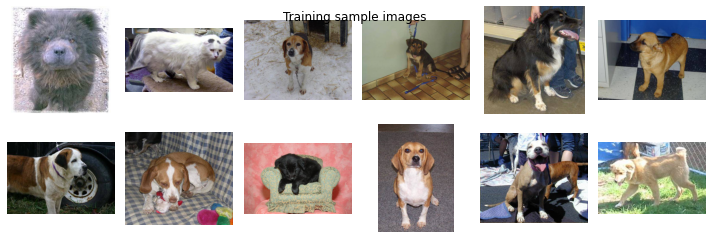

In [ ]:
fig = plt.figure(1, figsize = (10, 10))
fig.suptitle("Training sample images ")

for i in range(12):

    plt.subplot(6, 6, i + 1)
    image = load_img(train_path + '/'+ df["image_name"][i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# Data Augmentation


### Create data augmentation object

In [ ]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1. / 255)

### Generate data sets

In [ ]:
train_generator = training_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 16000 validated image filenames belonging to 2 classes.


In [ ]:
val_generator = validation_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = validation_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed)

Found 5000 validated image filenames belonging to 2 classes.


### Visualize the augmented data

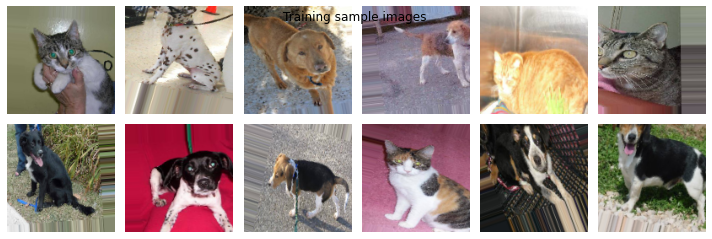

In [ ]:
fig = plt.figure(1, figsize = (10, 10))
fig.suptitle("Training sample images ")

for i in range(12):

    plt.subplot(6, 6, i + 1)
    image, label = train_generator.next()
     # display the image from the iterator
    plt.imshow(image[0])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# Model

### Define the learning curve

In [ ]:
# Plot the learning curve 
def learning_curve(history,filename):
    # history.history is a dictionary containing the loss and measurements. 
    # Change it to DataFrame, then method plot() can be used to get the learning curves.
    df = pd.DataFrame(history.history)
    df.tail(1).to_csv(filename+'_metrics.csv')
    print('Training metrics: ')
    print(df.tail(1))
    df.plot(figsize=(8, 5)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # Set the vertical range to [0,1]
    plt.show()
   

### Define  callbacks

In [ ]:
early_stop = EarlyStopping(patience=10)

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
mc = ModelCheckpoint(filepath = './best_model.h5',save_best_only=True,
                                                     verbose=0)
# model_chkpt = ModelCheckpoint('save_at_{epoch}.h5')

callbacks = [
    early_stop,
    lr_reduction,
    mc
]

### Build a model

In [ ]:
def CNN():

  model=Sequential()

  model.add(Conv2D(32,(3,3),activation='relu',input_shape=image_size+(3,)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
model=CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### Train the model

CNN
training the model...
Epoch 1/2
500/500 [==============================] - 750s 1s/step - loss: 0.7563 - accuracy: 0.5000 - val_loss: 0.9463 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/2
500/500 [==============================] - 749s 1s/step - loss: 0.6152 - accuracy: 0.5000 - val_loss: 0.5556 - val_accuracy: 0.4792 - lr: 0.0010
It takes  27 mins to train the model.
Test acc: 0.5
Training metrics: 
       loss  accuracy  val_loss  val_accuracy     lr
1  0.615228       0.5  0.555632      0.479167  0.001


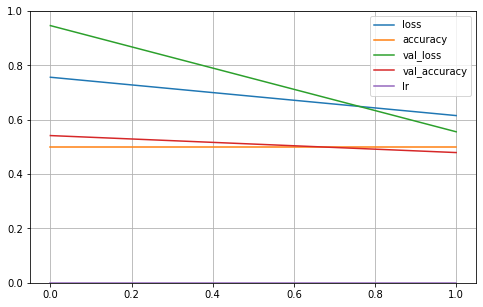

In [ ]:
model_name = 'CNN'
print(model_name)
# training
print('training the model...')
start = time()
with tf.device("/GPU:0"): # use GPU-kernel 
  hist = model.fit(train_generator,
          validation_data = val_generator,
          epochs=epoch,
          batch_size=batch_size,
          verbose = 1,
          validation_steps=3,
          callbacks=callbacks)
print('It takes ',round((time()-start)/60), 'mins to train the model.')

model.save('./final_' + model_name +'.h5')
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print('Test acc:', test_acc)
learning_curve(hist, model_name)

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()